Training Data Head:
    Employee ID  Age  Gender  Years at Company    Job Role  Monthly Income  \
0         8410   31    Male                19   Education            5390   
1        64756   59  Female                 4       Media            5534   
2        30257   24  Female                10  Healthcare            8159   
3        65791   36  Female                 7   Education            3989   
4        65026   56    Male                41   Education            4821   

  Work-Life Balance Job Satisfaction Performance Rating  Number of Promotions  \
0         Excellent           Medium            Average                     2   
1              Poor             High                Low                     3   
2              Good             High                Low                     0   
3              Good             High               High                     1   
4              Fair        Very High            Average                     0   

   ... Number of Dependents  

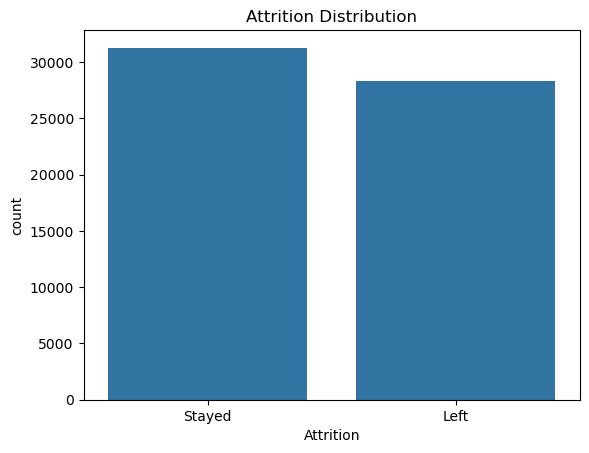

Processed Training Data Shape: (59598, 42)
Processed Test Data Shape: (14900, 42)

Processed Training Data Head:
    Age  Years at Company  Monthly Income  Number of Promotions  \
0   31                19            5390                     2   
1   59                 4            5534                     3   
2   24                10            8159                     0   
3   36                 7            3989                     1   
4   56                41            4821                     0   

   Distance from Home  Number of Dependents  Company Tenure  Attrition  \
0                  22                     0              89          0   
1                  21                     3              21          0   
2                  11                     3              74          0   
3                  27                     2              50          0   
4                  71                     0              68          0   

   Gender_Male  Job Role_Finance  ...  Compa

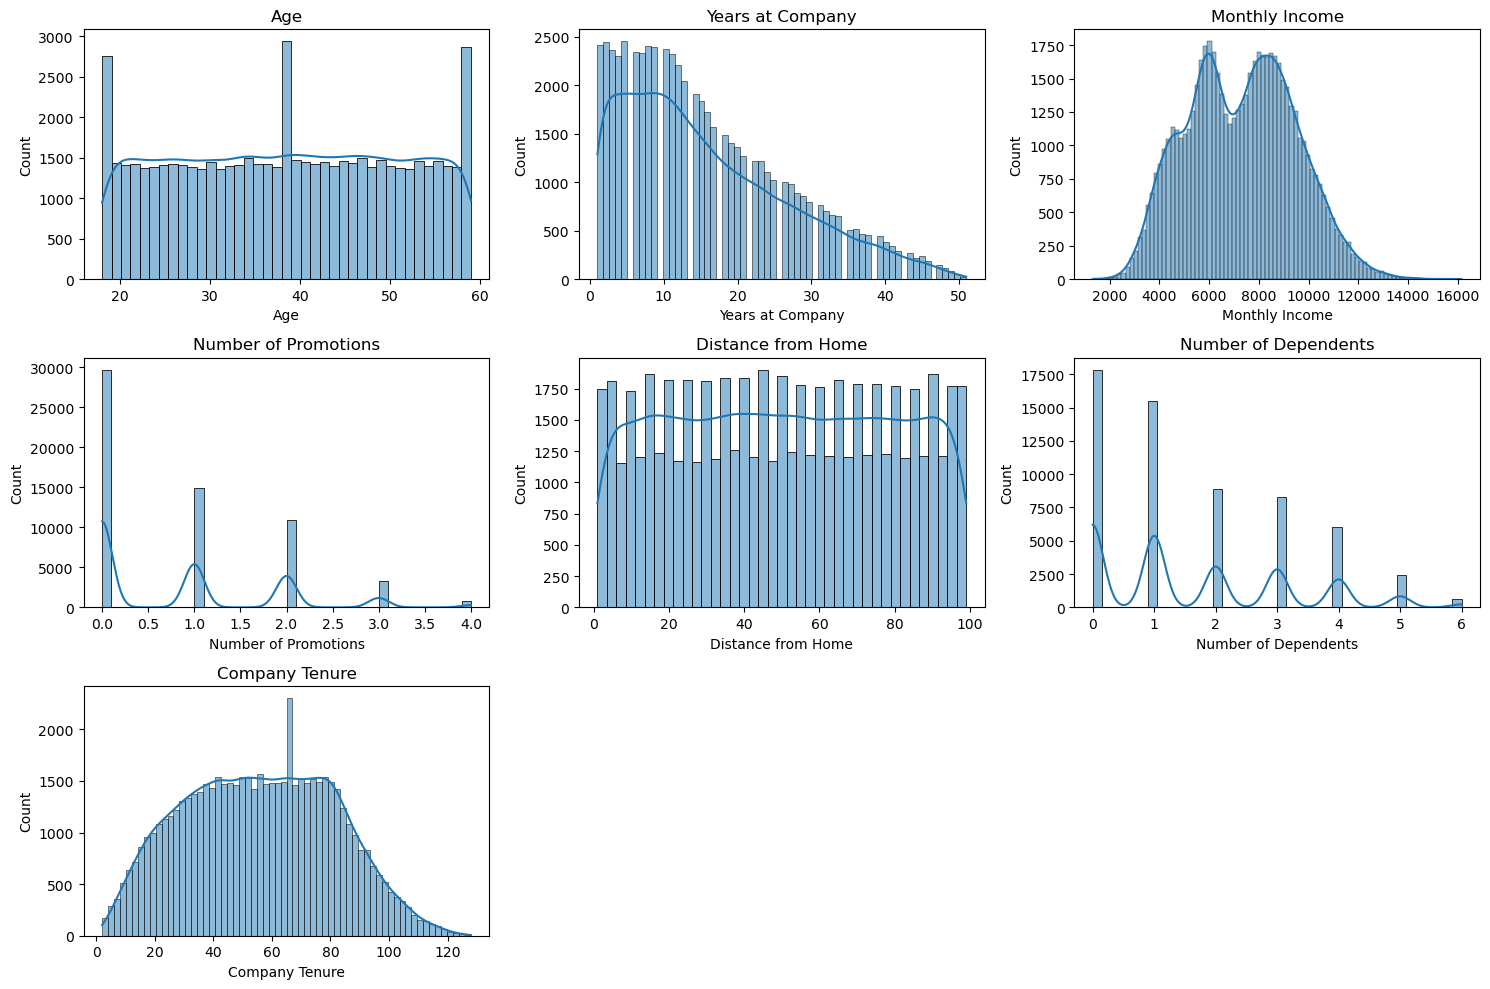

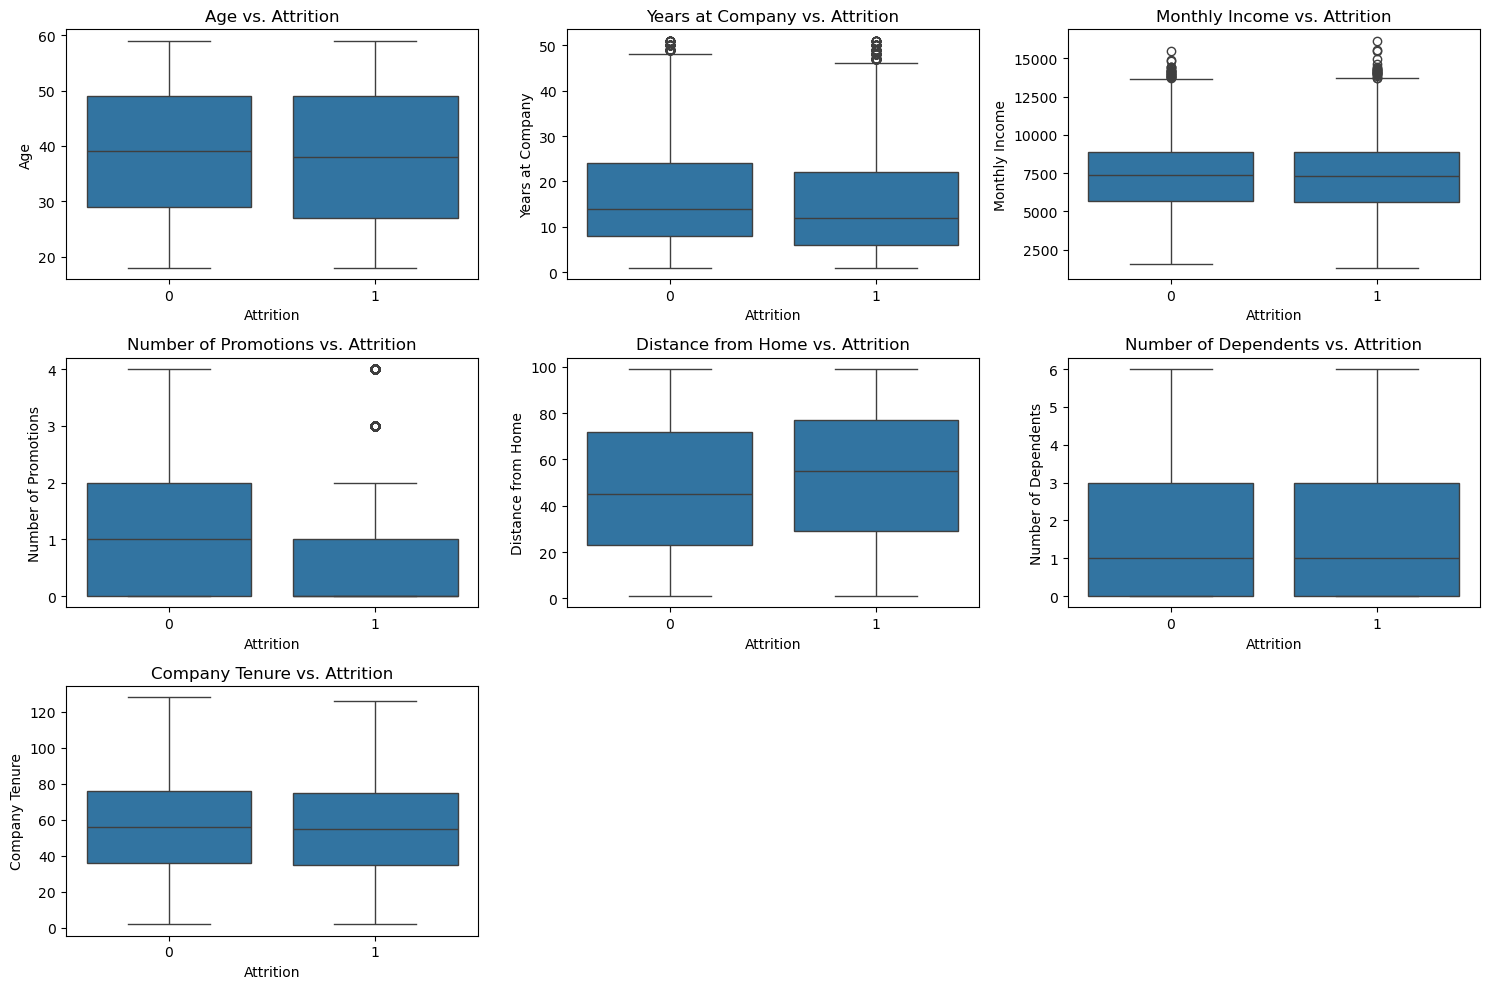

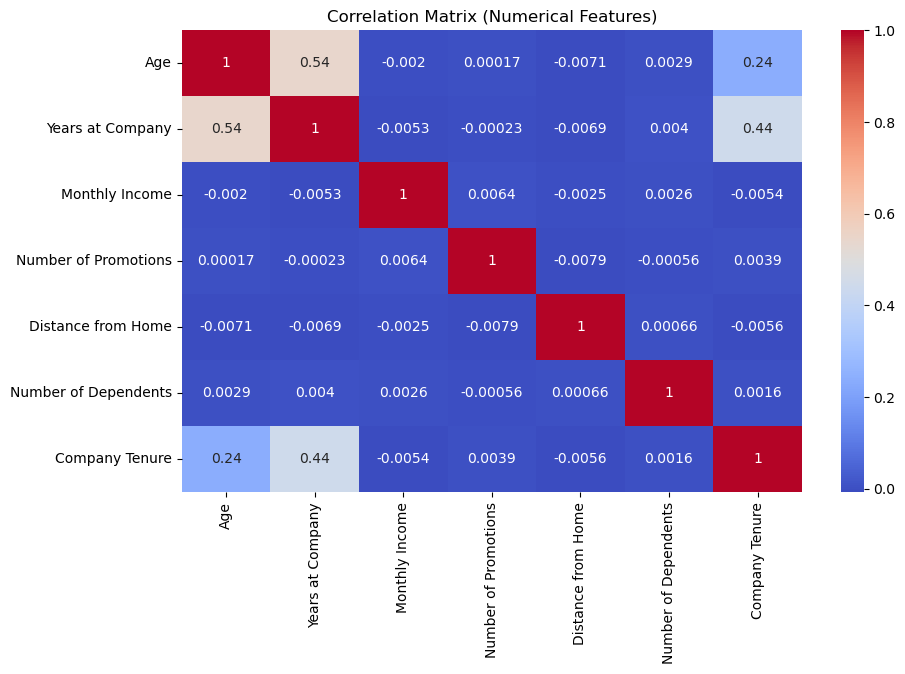

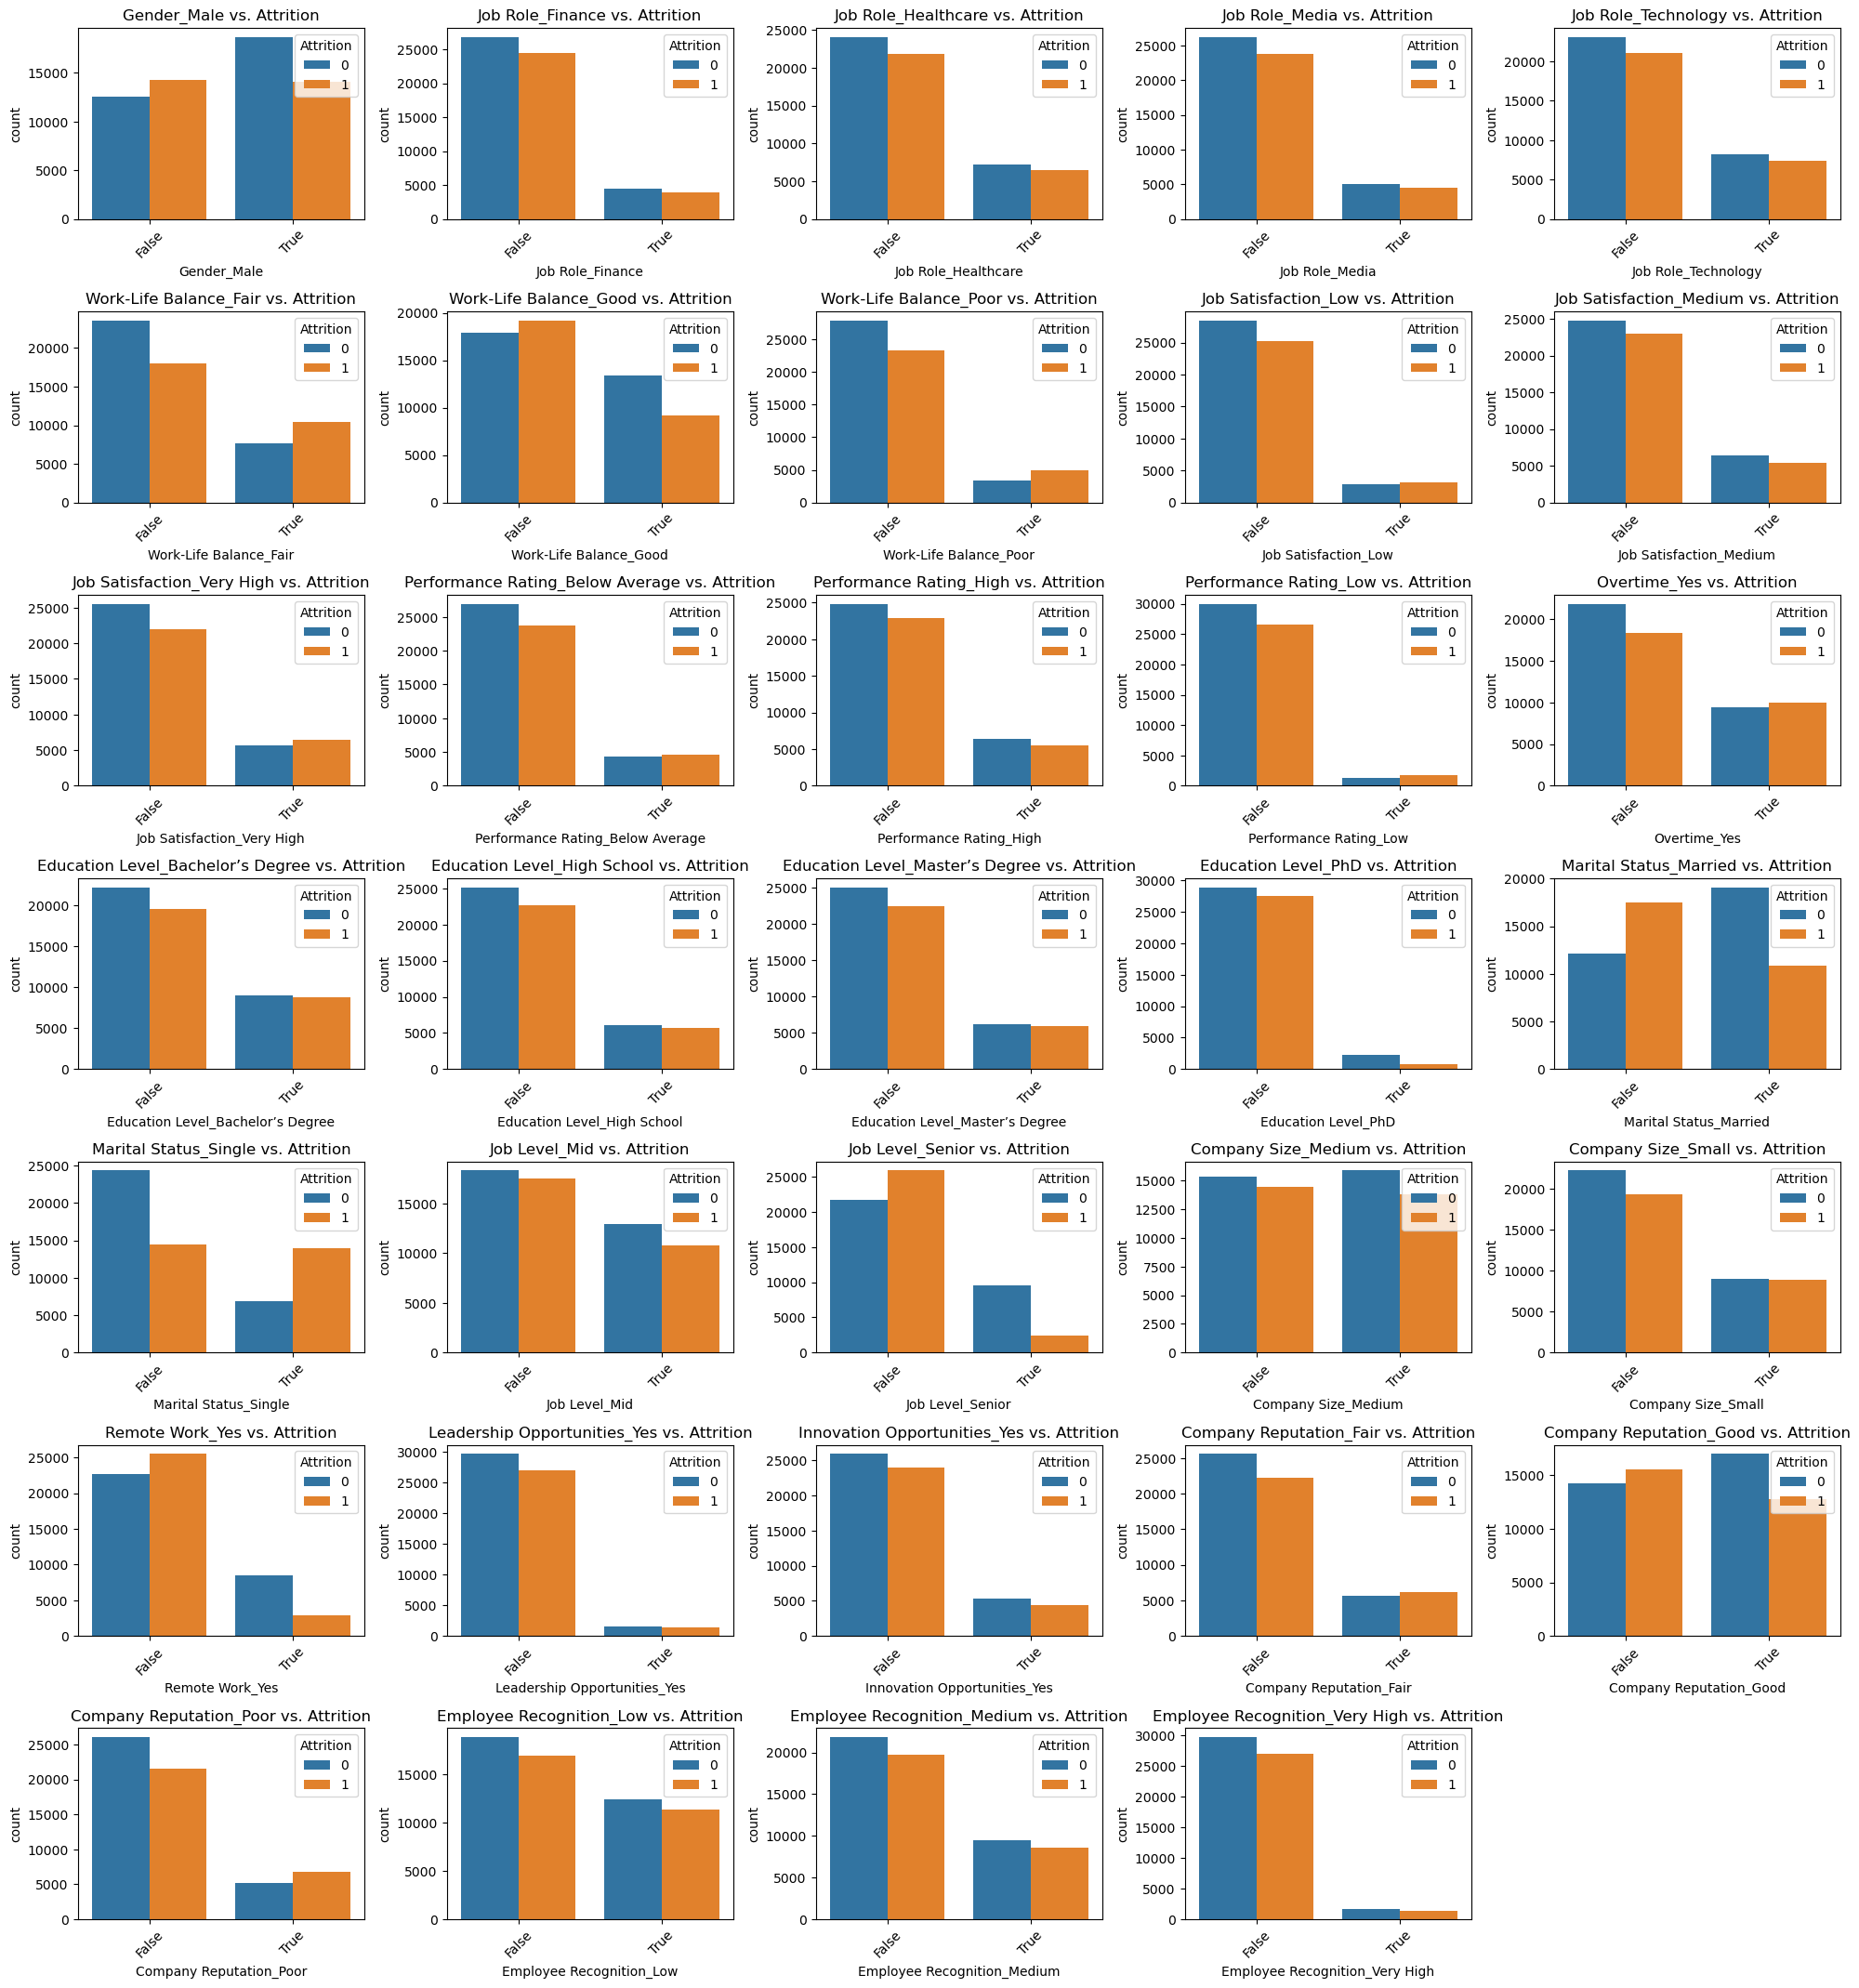

XGBoost Evaluation:
Accuracy: 0.7458892617449664
Precision: 0.7298710352039038
Recall: 0.7390153520381154
F1-score: 0.7344147303814117
AUC-ROC: 0.7455671674631644


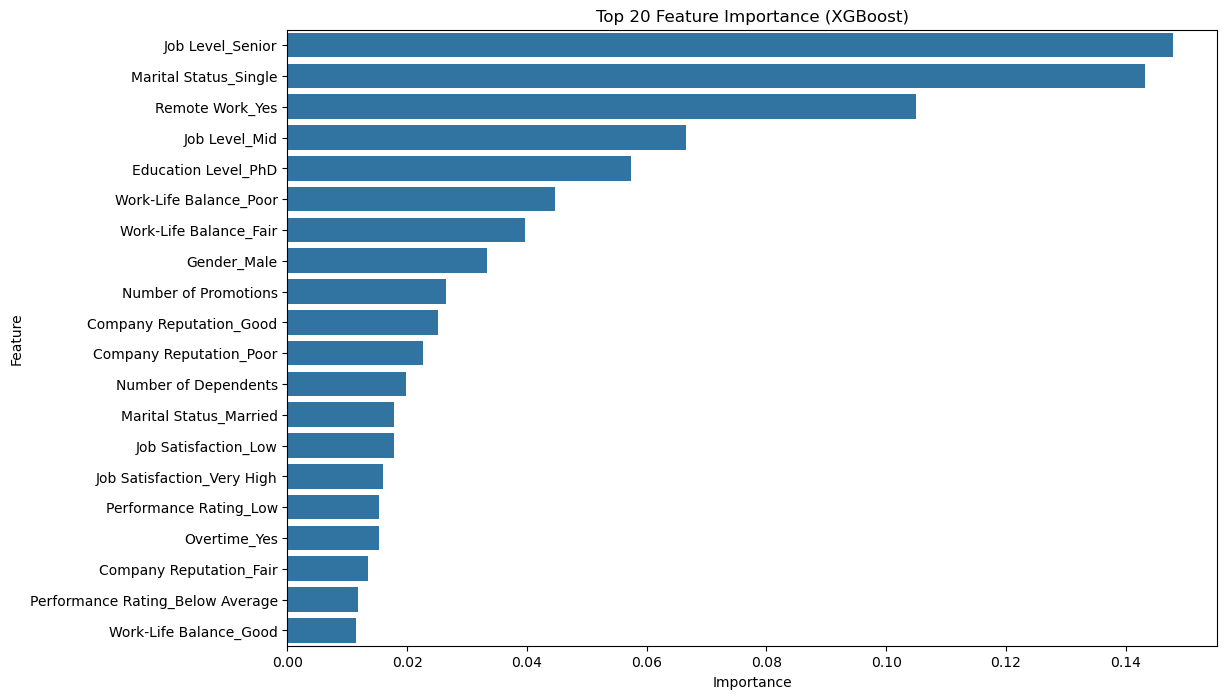

Top 10 Important Features:
                     Feature  Importance
29         Job Level_Senior    0.147933
27    Marital Status_Single    0.143318
32          Remote Work_Yes    0.104934
28            Job Level_Mid    0.066549
25      Education Level_PhD    0.057356
14   Work-Life Balance_Poor    0.044713
12   Work-Life Balance_Fair    0.039624
7               Gender_Male    0.033360
3      Number of Promotions    0.026437
36  Company Reputation_Good    0.025085

Logistic Regression Evaluation (Top Features):
Accuracy: 0.7385067114093959
Precision: 0.728740581270183
Recall: 0.7167813658020117
F1-score: 0.7227115025353616
AUC-ROC: 0.7374887158451926


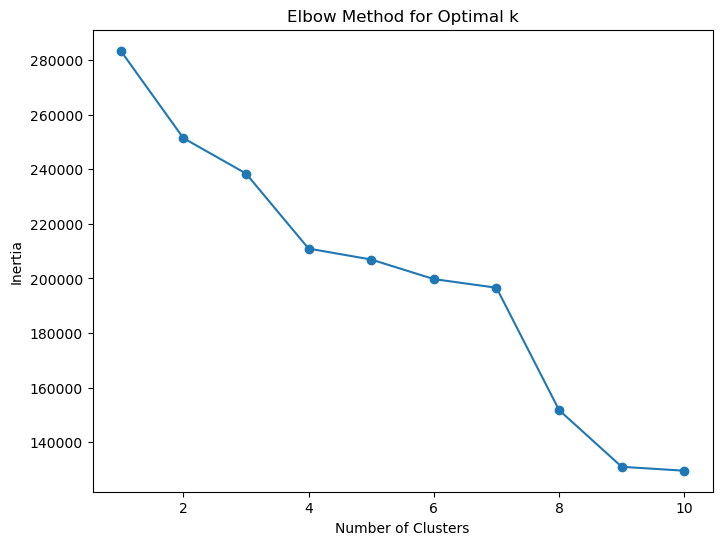

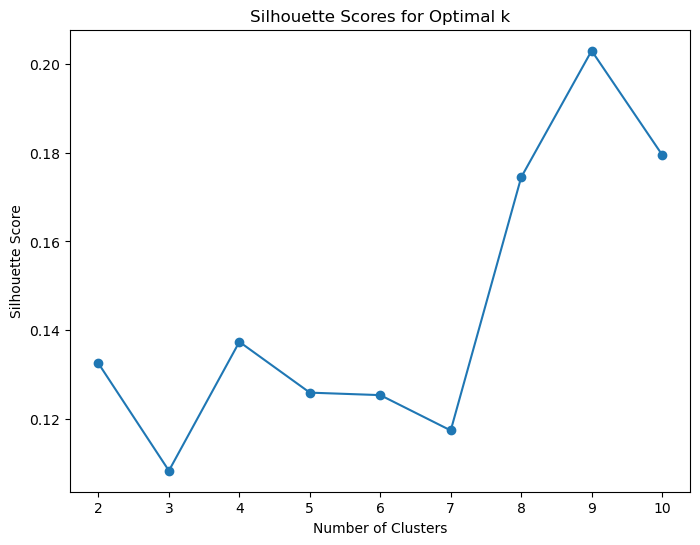

Cluster Means:
          Job Level_Senior  Marital Status_Single  Remote Work_Yes  \
Cluster                                                             
0                0.000000               0.359676         0.091267   
1                0.094919               0.454095         0.111726   
2                0.173271               0.687969         0.094490   

         Job Level_Mid  Education Level_PhD  Work-Life Balance_Poor  \
Cluster                                                               
0             0.536922             0.025513                0.280543   
1             0.391431             0.030118                0.000000   
2             0.192431             0.025229                0.272165   

         Work-Life Balance_Fair  Gender_Male  Number of Promotions  \
Cluster                                                              
0                      0.000000     0.353557              0.275565   
1                      1.000000     0.503838              0.735840   
2 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings

warnings.filterwarnings('ignore')

# Step 1: Data Loading and Initial Exploration
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Training Data Head:\n", train_df.head())
print("\nTest Data Head:\n", test_df.head())
print("\nTraining Data Info:\n", train_df.info())
print("\nTest Data Info:\n", test_df.info())
print("\nTraining Data Summary Statistics:\n", train_df.describe())
print("\nAttrition Distribution (Training Data):\n", train_df['Attrition'].value_counts())

sns.countplot(x='Attrition', data=train_df)
plt.title('Attrition Distribution')
plt.show()

# Step 2: Data Preprocessing
train_df = train_df.drop('Employee ID', axis=1)
test_df = test_df.drop('Employee ID', axis=1)

categorical_cols = train_df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Attrition')

train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

train_df['Attrition'] = train_df['Attrition'].map({'Stayed': 0, 'Left': 1})
test_df['Attrition'] = test_df['Attrition'].map({'Stayed': 0, 'Left': 1})

print("Processed Training Data Shape:", train_df.shape)
print("Processed Test Data Shape:", test_df.shape)
print("\nProcessed Training Data Head:\n", train_df.head())

# Step 3: EDA
numerical_cols = ['Age', 'Years at Company', 'Monthly Income', 'Number of Promotions', 'Distance from Home', 'Number of Dependents', 'Company Tenure']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Attrition', y=col, data=train_df)
    plt.title(col + ' vs. Attrition')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

categorical_features = [col for col in train_df.columns if col not in numerical_cols and col != 'Attrition']

plt.figure(figsize=(20, 30))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(10, 5, i)
    sns.countplot(x=col, hue='Attrition', data=train_df)
    plt.title(col + ' vs. Attrition')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Model Building (Classification)
X = train_df.drop('Attrition', axis=1)
y = train_df['Attrition']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)


print("XGBoost Evaluation:")
print("Accuracy:", accuracy_score(y_val, xgb_pred))
print("Precision:", precision_score(y_val, xgb_pred))
print("Recall:", recall_score(y_val, xgb_pred))
print("F1-score:", f1_score(y_val, xgb_pred))
print("AUC-ROC:", roc_auc_score(y_val, xgb_pred))


# Step 5: Feature Importance Analysis
xgb.fit(X, y)
feature_importance = xgb.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance (XGBoost)')
plt.show()

print("Top 10 Important Features:\n", feature_importance_df.head(10))

# Step 6: Logistic Regression
top_features = ['Job Level_Senior', 'Marital Status_Single', 'Remote Work_Yes', 'Job Level_Mid', 'Education Level_PhD', 'Work-Life Balance_Poor', 'Work-Life Balance_Fair', 'Gender_Male', 'Number of Promotions', 'Company Reputation_Good']
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_top, y_train)
logreg_pred = logreg.predict(X_val_top)

print("\nLogistic Regression Evaluation (Top Features):")
print("Accuracy:", accuracy_score(y_val, logreg_pred))
print("Precision:", precision_score(y_val, logreg_pred))
print("Recall:", recall_score(y_val, logreg_pred))
print("F1-score:", f1_score(y_val, logreg_pred))
print("AUC-ROC:", roc_auc_score(y_val, logreg_pred))

# Step 7: K-Means Clustering
attrition_df = train_df[train_df['Attrition'] == 1]
X_cluster = attrition_df[top_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_
attrition_df['Cluster'] = labels

cluster_means = attrition_df.groupby('Cluster')[top_features].mean()
print("Cluster Means:\n", cluster_means)

# Step 8: Neural Network
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
nn_pred = (model.predict(X_val) > 0.5).astype(int)

print("Neural Network Evaluation:")
print("Accuracy:", accuracy_score(y_val, nn_pred))
print("Precision:", precision_score(y_val, nn_pred))
print("Recall:", recall_score(y_val, nn_pred))
print("F1-score:", f1_score(y_val, nn_pred))
print("AUC-ROC:", roc_auc_score(y_val, nn_pred))